<a href="https://colab.research.google.com/github/aiojoawo/skin-disease-classification/blob/main/skin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os


**Data Cleaning**: *Remove weird images: Before importing the data, you can do some manual filtering by removing images below 10kb in each class folder or irrelevant images from google search*


In [2]:
import cv2
import imghdr

In [3]:
from google.colab import drive
#drive.mount('/content/drive'), you can mount the drive by uncommenting this line
data_dir= '/content/drive/MyDrive/Skin_data'

Filter out unwanted image
file type

In [4]:
image_exts = ['jpeg','jpg', 'bmp','png']

In [5]:
from posix import listdir


for image_class in os.listdir(data_dir): #for each subfolder in Skin_data
    for image in os.listdir(os.path.join(data_dir, image_class)): #for each image in the subfolder
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

***Load Images***

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
#build data pipeline
data=tf.keras.utils.image_dataset_from_directory(data_dir)


Found 494 files belonging to 2 classes.


In [8]:
#class names
data_class=data.class_names
data_class

['pityriasis rosea', 'ringworm']

In [9]:
for image_batch, labels_batch in data.take(1):#take one batch
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1]


32 represent the number of images in one batch, each image size is (256,256) and 3 indicates that the image has color

label batch.numpy is the array thatstores the class for the images in the batch


In [10]:
IMG_SIZE=image_batch[0].shape
IMG_SIZE

TensorShape([256, 256, 3])

[1, 0]


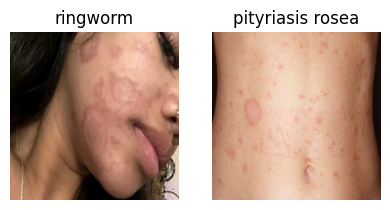

In [28]:
labels=[]
#visualize the image and the labels
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in data.take(1):#get 1 batch
  for i in range(2):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))#one image from the batch
    plt.title(data_class[labels_batch[i]])#image class
    labels.append(labels_batch[i].numpy())
    plt.axis('off')
print(labels)

0: pityriasis rosea, 1: ringworm

**Preprocess images**:

*Split Data*

In [12]:
train_split=0.8
val_split=0.1
test_split=0.1


def data_split(ds,train_split,val_split,test_split):
  ds_size=len(ds)#number of batches in dataset

  train_size=int(train_split*ds_size)#number of batches in train dataset
  val_size = int(val_split*ds_size)#number of batches in validation dataset
  test_size=int(test_split*ds_size)#number of batches in test dataset

  #take train_split ratio from overall dataset
  train_ds=ds.take(train_size)

  #skip the data in the train dataset, then take val_split ratio of the remaining dataset
  val_ds=ds.skip(train_size).take(val_size)

  #skip the data in both the train and validation dataset, then take test_split ratio of the remaining dataset
  test_ds=ds.skip(train_size).skip(val_size).take(test_size)
  return train_ds,val_ds,test_ds

train_ds,val_ds,test_ds=data_split(data,train_split,val_split,test_split)

In [13]:
print(len(data),len(train_ds),len(val_ds),len(test_ds))

16 12 1 1


*Data augmentation to prevent overfitting*

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
#load images using buffered prefetching
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)
#

In [16]:
#apply data augmentation to prevent overfitting
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  layers.RandomZoom(0.5),
                                          ])

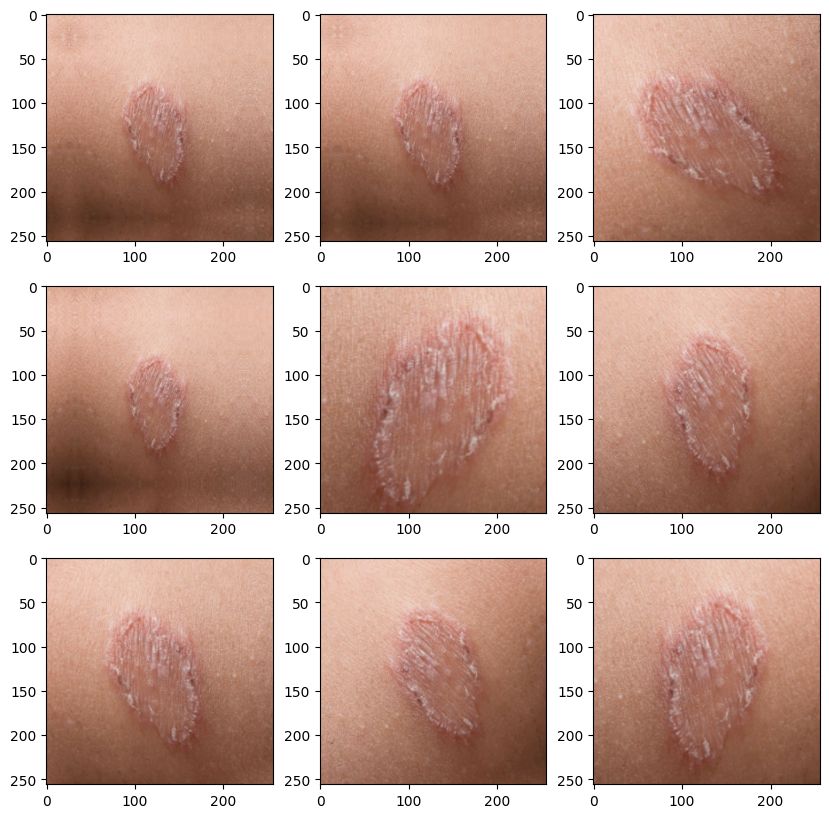

In [29]:
#visualize transformations on one batch of the training dataset
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0]/255)


**Model building: Implement Transfer Learning**

In [18]:
#create base_model with Xception pre-trained model;


base_model = tf.keras.applications.Xception(input_shape=IMG_SIZE,
                                               include_top=False,#don't include the output layer of the pretrained model due to difference in no of class
                                               weights='imagenet')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#specify input shape
inputs=tf.keras.Input(shape=(IMG_SIZE))

#apply data augmentation to the inputs
x=data_augmentation(inputs)

#rescale input pixels to match the model's input scale
#xception requires input to be in the range (-1,1)

x= tf.keras.applications.xception.preprocess_input(x)

#run on inference model by freezing the model layers so they are not updated during training
x=base_model(x, training = False)

#convert features from base_model to vectors
x=tf.keras.layers.GlobalAveragePooling2D()(x)

#add dropout regularization to prevent overfitting
x=tf.keras.layers.Dropout(0.2)(x)

#define output layer
outputs= keras.layers.Dense(1)(x)

#define model
model = keras.Model(inputs,outputs)
#

In [ ]:
#compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5,name='accuracy')])

In [ ]:
#fit the model
history = model.fit(train_ds,epochs=20,validation_data=val_ds)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 512s 40s/step - accuracy: 0.6437 - loss: 0.7040 - val_accuracy: 0.6250 - val_loss: 0.6755
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 485s 40s/step - accuracy: 0.5992 - loss: 0.6700 - val_accuracy: 0.6875 - val_loss: 0.6008
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 474s 39s/step - accuracy: 0.6355 - loss: 0.6696 - val_accuracy: 0.5938 - val_loss: 0.6137
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 511s 40s/step - accuracy: 0.6875 - loss: 0.6337 - val_accuracy: 0.6875 - val_loss: 0.5721
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 482s 40s/step - accuracy: 0.6824 - loss: 0.6302 - val_accuracy: 0.6250 - val_loss: 0.5821
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 471s 39s/step - accuracy: 0.6210 - loss: 0.6066 - val_accuracy: 0.7812 - val_loss: 0.5135
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 503s 39s/step - accuracy: 0.7202 - loss: 0.5940 - val_accuracy: 0.7812 - val_loss: 0.4858
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 473s 40s/step - accuracy: 0.6710 - loss: 0.5731 - val_accuracy: 0.

In [ ]:
for image_batch, labels_batch in test_ds.take(1):#take one batch
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1]


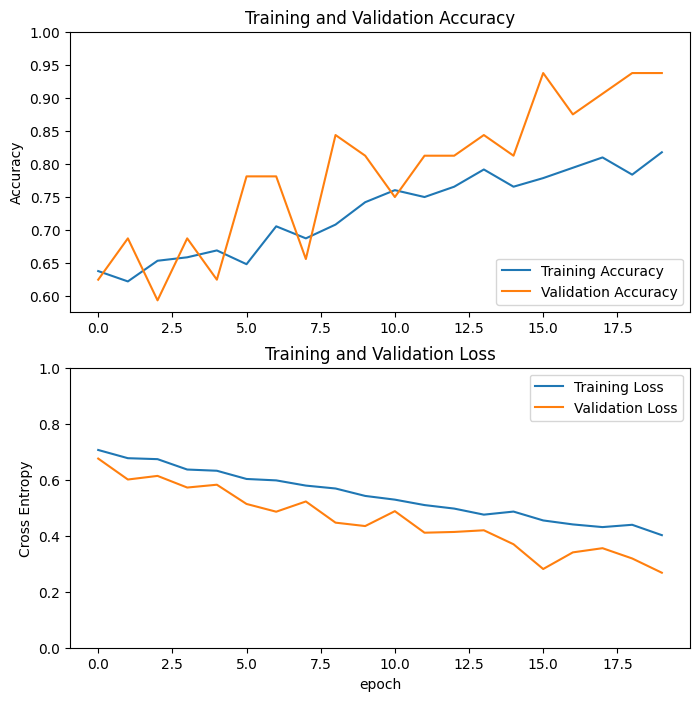

In [ ]:
#Plot accuracy and loss result for both training and validation dataset
training_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

training_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(training_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

You can save the model using model.save('my_model.keras')

In [25]:
#You can import the saved model

# Check if the model file exists
if not os.path.exists('/content/my_model.keras'):
    print("Error: Model file 'my_model.keras' not found. Please ensure the file exists and the path is correct.")
else:
    # Load the model
    new_model = tf.keras.models.load_model('/content/my_model.keras')
    print("Model loaded successfully.")

Model loaded successfully.


In [28]:
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 8, 8, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,481,533 (238.35 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 41,618,004 (158.76 MB)

**Test the model on imported images**

In [46]:
from tensorflow.keras.preprocessing import image
import numpy as np

#specify image path
img_path='/content/test_image_1.jpg'

#load image and specify size
x=image.load_img(img_path,target_size=(256,256))

#convert to array
x=image.img_to_array(x)

#create a batch for the image; the batch should have just one image
x=np.expand_dims(x,axis=0)

#make predictions, model outputs logits
logits=new_model.predict(x)

#convert logits to probabilities
preds=tf.nn.sigmoid(logits)
#get label_index from maximum probabilities or np.where(preds.numpy()>0.5,1,0)
label_index=np.argmax(preds)

from tensorflow.keras.preprocessing import image
import numpy as np

#specify image path
img_path='/content/test_image_1.jpg'

#load image and specify size
x=image.load_img(img_path,target_size=(256,256))

#convert to array
x=image.img_to_array(x)

#create a batch for the image; the batch should have just one image
x=np.expand_dims(x,axis=0)

#make predictions, model outputs logits
logits=new_model.predict(x)

#convert logits to probabilities
preds=tf.nn.sigmoid(logits)
#get label_index from maximum probabilities or np.where(preds.numpy()>0.5,1,0)
label_index=np.argmax(preds)

label=data_class[label_index]
print('actual label: pityriasis rosea')
print('predicted label:', label)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
actual label: pityriasis rosea
predicted label: pityriasis rosea


In [47]:
img_path= '/content/Ringworm_on_skin.width-1534.jpeg'
x=image.load_img(img_path, target_size = (256,256))
x=image.img_to_array(x)
x= np.expand_dims(x,axis=0)
logits = new_model.predict(x)
preds = tf.nn.sigmoid(logits)
label_index=np.where(preds.numpy()>0.5,1,0)
label = data_class[label_index[0][0]]
print('actual label: ringworm')
print('predicted label:', label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
actual label: ringworm
predicted label: ringworm
